# Comparison of neural Models
This notebook creates a comparison of how our neural models perform. We will try each model with and without word embeddings, and produce visualisations of model performance. 

# Feed-Forward Neural Networks
First we will find this difference for Feed-Forward Neural Networks (FFNN):

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Embedding, Flatten, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from scripts import training_helpers
from sklearn.model_selection import train_test_split, StratifiedKFold

from gensim.models import KeyedVectors
from seaborn import boxplot
from pandas import DataFrame

We will cross validate our model, so lets create a function to handle this for us. It will use StratifiedKFold splitting:

In [64]:
def run_cross_validate(get_model, X, y, cv=5, categorical=False):
  skfSplitter = StratifiedKFold(n_splits=cv, shuffle=True)
  metrics = {
    "accuracies": [],
  }
    
  for train_indices, test_indices in skfSplitter.split(X, y):
    training_X = np.array([X[x] for x in train_indices])
    training_y = [y[x] for x in train_indices]
    test_X = np.array([X[x] for x in test_indices])
    test_y = [y[x] for x in test_indices]
    
    if categorical:
      training_y = to_categorical(training_y)
      test_y = to_categorical(test_y)
    
    model = get_model()
    model.fit(np.array(training_X), training_y, epochs=12, batch_size=16, validation_split=0.3,
              callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
    metrics["accuracies"].append(model.evaluate(np.array(test_X), test_y)[1])
  return metrics

First we find results for our Bag of Words (BoW) model:

In [4]:
data_frame = training_helpers.get_data_frame()

predictors_raw = data_frame['review']
num_words = 20000

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(predictors_raw)
bow_predictors = tokenizer.texts_to_matrix(predictors_raw, mode='tfidf')
labels = [x for x in data_frame['deceptive']]

In [3]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(num_words,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

ff_bow_scores = run_cross_validate(get_ff_bow_model, bow_predictors, labels, cv=2)

Train on 560 samples, validate on 240 samples
Epoch 1/12
560/560 [==============================] - 1s 3ms/step - loss: 0.8071 - acc: 0.6446 - val_loss: 0.6504 - val_acc: 0.8208
Epoch 2/12
560/560 [==============================] - 0s 804us/step - loss: 0.4659 - acc: 0.9321 - val_loss: 0.5257 - val_acc: 0.8625
Epoch 3/12
560/560 [==============================] - 0s 805us/step - loss: 0.3024 - acc: 0.9732 - val_loss: 0.4687 - val_acc: 0.8750
Epoch 4/12
560/560 [==============================] - 0s 856us/step - loss: 0.2227 - acc: 0.9929 - val_loss: 0.4506 - val_acc: 0.8625
Epoch 5/12
560/560 [==============================] - 0s 886us/step - loss: 0.2027 - acc: 0.9929 - val_loss: 0.4386 - val_acc: 0.8583
Epoch 6/12
560/560 [==============================] - 0s 849us/step - loss: 0.1701 - acc: 0.9982 - val_loss: 0.4258 - val_acc: 0.8708
Epoch 7/12
560/560 [==============================] - 0s 794us/step - loss: 0.1639 - acc: 0.9946 - val_loss: 0.4257 - val_acc: 0.8750
Epoch 8/12
560/560

And for our word vector method. First we must create our word vectors using a word vectorizing model generated in another experiment:

In [5]:
word_vectors = KeyedVectors.load("opspam_w2v.kv", mmap="r")

predictors_sequences = pad_sequences(tokenizer.texts_to_sequences(predictors_raw))
max_sequence_length = max([len(x) for x in predictors_sequences])

In [6]:
embedding_length = word_vectors.vector_size

corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1
vectorizer_words = word_vectors.wv
embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, idx in corpus_words.items():
  if word in vectorizer_words.vocab:
    embedding_matrix[idx] = np.array(vectorizer_words[word], dtype=np.float32)

In [6]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=max_sequence_length),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)), #, input_shape=(num_words,)
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_ff_wv

ff_wv_scores = run_cross_validate(get_ff_wv_model, predictors_sequences, labels, cv=10)

Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 4s 4ms/step - loss: 0.8892 - acc: 0.5114 - val_loss: 0.8111 - val_acc: 0.5681
Epoch 2/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7886 - acc: 0.5968 - val_loss: 0.7751 - val_acc: 0.6189
Epoch 3/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7564 - acc: 0.6216 - val_loss: 0.7772 - val_acc: 0.6005
Epoch 4/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7434 - acc: 0.6504 - val_loss: 0.7879 - val_acc: 0.6143
Epoch 5/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6938 - acc: 0.6862 - val_loss: 0.7597 - val_acc: 0.6189
Epoch 6/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6735 - acc: 0.6951 - val_loss: 0.7771 - val_acc: 0.6328
Epoch 7/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.6624 - acc: 0.7051 - val_loss: 0.7744 - val_acc: 0.6005
Epoch 8/12
1007

Epoch 3/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7586 - acc: 0.4975 - val_loss: 0.7512 - val_acc: 0.5358
Epoch 4/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7373 - acc: 0.4965 - val_loss: 0.7273 - val_acc: 0.5081
Epoch 5/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7221 - acc: 0.4777 - val_loss: 0.7171 - val_acc: 0.5081
Epoch 6/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7135 - acc: 0.4965 - val_loss: 0.7101 - val_acc: 0.5081
Epoch 7/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7077 - acc: 0.4965 - val_loss: 0.7053 - val_acc: 0.5081
Epoch 8/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7036 - acc: 0.4995 - val_loss: 0.7020 - val_acc: 0.4919
Epoch 9/12
1007/1007 [==============================] - 2s 2ms/step - loss: 0.7007 - acc: 0.5035 - val_loss: 0.6996 - val_acc: 0.4919
Epoch 10/12
1007/1007 [==============================] - 2s 2m

In [7]:
print ("Bag of words: ", ff_bow_scores['accuracies'])
print ("Word vectors: ", ff_wv_scores['accuracies'])

ff_scores_entries =[('Bag of Words', x) for x in ff_bow_scores['accuracies']] + [('Word Vectors', x) for x in ff_wv_scores['accuracies']]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.84375, 0.89375, 0.8625, 0.90625, 0.85, 0.8375, 0.875, 0.8625, 0.875, 0.8875]
Word vectors:  [0.64375, 0.625, 0.59375, 0.54375, 0.6, 0.5, 0.56875, 0.53125, 0.575, 0.56875]


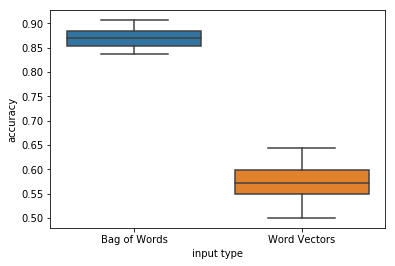

In [8]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()

The results are very strange! How could word vectors be less accurate than bag of words? This is known to occur when two conditions are met:
    
* The dataset is small
* The dataset is very domain specific

It is possible that these conditions actually are met here. The problem however is that running these models over our full dataset will take much longer, and will require a commited experiment to complete the investigation.

# Convolutional Network

In [6]:
bow_predictors.shape

(1600, 20000)

In [75]:
batches = 1600
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in bow_predictors]), batches))
convolutional_data.shape

(1600, 1, 20000, 1)

In [76]:
def get_conv_bow_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(1, 10),
          data_format="channels_last",
          input_shape=(1, 20000, 1),
          activation=relu),
      MaxPooling2D(pool_size=(1, 10)),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [77]:
conv_bow_scores = run_cross_validate(get_conv_bow_model, convolutional_data, labels, cv=2, categorical=True)

Train on 560 samples, validate on 240 samples
Epoch 1/12
560/560 [==============================] - 13s 23ms/step - loss: 0.5304 - acc: 0.7357 - val_loss: 0.6516 - val_acc: 0.6667
Epoch 2/12
560/560 [==============================] - 11s 19ms/step - loss: 0.1653 - acc: 0.9589 - val_loss: 0.7696 - val_acc: 0.6292
Epoch 3/12
560/560 [==============================] - 10s 18ms/step - loss: 0.0820 - acc: 0.9804 - val_loss: 0.7386 - val_acc: 0.6708
Epoch 4/12
560/560 [==============================] - 11s 20ms/step - loss: 0.0499 - acc: 0.9946 - val_loss: 0.9655 - val_acc: 0.5708
Epoch 5/12
800/800 [==============================] - 7s 8ms/step
Train on 560 samples, validate on 240 samples
Epoch 1/12
560/560 [==============================] - 13s 24ms/step - loss: 0.5012 - acc: 0.7679 - val_loss: 0.6617 - val_acc: 0.6292
Epoch 2/12
560/560 [==============================] - 9s 16ms/step - loss: 0.1410 - acc: 0.9696 - val_loss: 0.7467 - val_acc: 0.6292
Epoch 3/12
560/560 [===================

In [8]:
def vectorize_review(review_words):
  sentence = []
  for word in review_words:
    if word in word_vectors.wv:
      sentence.append(word_vectors.wv['dog'])
  return np.array(sentence, np.float64)

In [9]:
def pad_vectorized_review(vectorized_review, length):
  return np.concatenate((vectorized_review, np.zeros((length - len(vectorized_review), 100))))

In [10]:
vectorized_reviews = [vectorize_review(text_to_word_sequence(x)) for x in predictors_raw]
pad_length = max([x.shape[0] for x in vectorized_reviews])
vectorized_reviews = np.array([[pad_vectorized_review(x, pad_length)] for x in vectorized_reviews])

In [11]:
print(vectorized_reviews.shape)

(1600, 1, 381, 100)


In [57]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 100),
          data_format="channels_first",
          input_shape=(1, 381, 100),
          activation=relu),
      MaxPooling2D(strides=(1, 1), pool_size=(2, 1), data_format="channels_first"),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [70]:
conv_wv_scores = run_cross_validate(get_conv_wv_model, vectorized_reviews, labels, cv=2, categorical=True)

Train on 560 samples, validate on 240 samples
Epoch 1/12
560/560 [==============================] - 5s 9ms/step - loss: 0.7025 - acc: 0.4911 - val_loss: 0.6932 - val_acc: 0.4917
Epoch 2/12
560/560 [==============================] - 3s 5ms/step - loss: 0.6923 - acc: 0.5429 - val_loss: 0.6993 - val_acc: 0.4625
Epoch 3/12
560/560 [==============================] - 3s 5ms/step - loss: 0.6823 - acc: 0.5571 - val_loss: 0.6747 - val_acc: 0.5792
Epoch 4/12
560/560 [==============================] - 3s 5ms/step - loss: 0.6699 - acc: 0.6304 - val_loss: 0.6840 - val_acc: 0.5833
Epoch 5/12
560/560 [==============================] - 3s 5ms/step - loss: 0.6463 - acc: 0.6589 - val_loss: 0.6832 - val_acc: 0.5667
Epoch 6/12
560/560 [==============================] - 3s 5ms/step - loss: 0.6338 - acc: 0.6393 - val_loss: 0.6863 - val_acc: 0.5875
Epoch 7/12
800/800 [==============================] - 1s 2ms/step
Train on 560 samples, validate on 240 samples
Epoch 1/12
560/560 [==============================

In [78]:
print ("Bag of words: ", conv_bow_scores['accuracies'])
print ("Word vectors: ", conv_wv_scores['accuracies'])

conv_scores_entries =[('Bag of Words', x) for x in conv_bow_scores['accuracies']] + [('Word Vectors', x) for x in conv_wv_scores['accuracies']]
conv_scores_data_frame = DataFrame(conv_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.82125, 0.7775]
Word vectors:  [0.48, 0.51625]


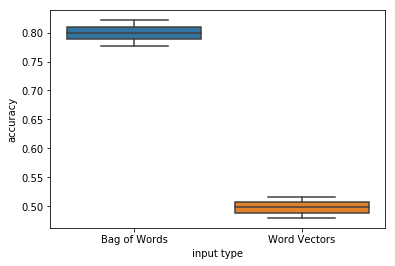

In [79]:
boxplot(x='input type', y='accuracy', data=conv_scores_data_frame)
plt.show()